In [1]:
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT 
#from psycopg2 import extras as ex
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
from sklearn.preprocessing import *
import datetime

In [2]:
import tensorflow as tf
from tensorflow.keras import *
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

## daily new case and predict

In [3]:
# connect to the postgresql
db_connection = psycopg2.connect(host='127.0.0.1',dbname="chicago_business_intelligence", user="postgres" , password="12345")
cursor = db_connection.cursor()

In [4]:
# get daily data
select_daily_data = (
    """
        SELECT * FROM "covid_daily_case";
    """)
# create the table
cursor.execute(select_daily_data)
result = cursor.fetchall();

<AxesSubplot:xlabel='time'>

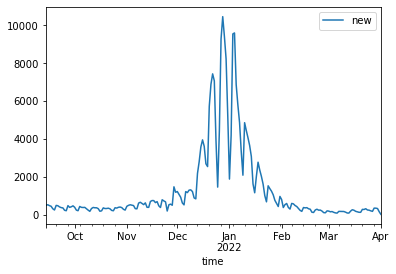

In [5]:
# set dataframe
daily = pd.DataFrame(result)
daily.columns = ["id_u","time","new","death"]
daily_new = daily[["time","new"]]
daily_new.plot(x = 'time', y = 'new')

In [6]:
# predict 
scaler = MinMaxScaler()
scaled_close_ori = [daily_new["new"][i] for i in range(len(daily_new["new"])-1,-1,-1)]
avg_item = np.average(scaled_close_ori[-10:])
scaled_close_ori = scaled_close_ori + [avg_item]*10
scaled_close = np.array(scaled_close_ori).reshape([len(scaled_close_ori),1])
scaled_close = scaler.fit_transform(scaled_close)
scaled_close = scaled_close.reshape(-1, 1)

In [7]:
SEQ_LEN = 10

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])
    #edit
    num_train = -10

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test =\
 preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [8]:
WINDOW_SIZE = SEQ_LEN - 1
model = keras.Sequential()
model.add(keras.Input(shape=(WINDOW_SIZE,X_train.shape[-1])))
model.add(LSTM(WINDOW_SIZE,dropout=0.2))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(layers.Dense(units=1, activation="linear"))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 9)                 396       
                                                                 
 dense (Dense)               (None, 30)                300       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,017
Trainable params: 1,017
Non-trainable params: 0
_________________________________________________________________


In [10]:
BATCH_SIZE = 16
model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
11/11 [==============================] - 2s 44ms/step - loss: 0.0509 - val_loss: 4.3962e-04
Epoch 2/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0429 - val_loss: 0.0021
Epoch 3/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0385 - val_loss: 0.0043
Epoch 4/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0350 - val_loss: 0.0063
Epoch 5/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0322 - val_loss: 0.0076
Epoch 6/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0307 - val_loss: 0.0080
Epoch 7/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0300 - val_loss: 0.0079
Epoch 8/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0285 - val_loss: 0.0074
Epoch 9/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0255 - val_loss: 0.0067
Epoch 10/50
11/11 [==============================] - 0s 5ms/step - loss: 0.0241 - val_loss: 0.0059
Epoch 11/50
11

In [11]:
y_hat = model.predict(X_test)
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

In [12]:
y_hat_inverse

array([[298.13123],
       [273.27823],
       [275.5232 ],
       [277.34628],
       [279.6558 ],
       [282.26767],
       [280.07733],
       [278.17014],
       [276.9908 ],
       [280.30606]], dtype=float32)

In [13]:
def alert_func(x):
    if x >300:
        return "high"
    elif 100 <x <300:
        return "medium"
    else:
        return "low"

In [14]:
pre_list = []
int_time = daily_new["time"][0]
for i in y_hat_inverse.tolist():
    value = i[0]
    int_time += datetime.timedelta(days=1)
    pre_list.append([int_time,value])
pre_list = [pre_list[i] for i in range(len(pre_list)-1,-1,-1)]
pre_list_df = pd.DataFrame(pre_list)
pre_list_df.columns=["time","new"]
new_case_pre_df = pre_list_df.append(daily_new)
new_case_pre_df["time"] = new_case_pre_df["time"].apply(lambda x:x.strftime("%Y-%m-%d"))
new_case_pre_df.dropna()
new_case_pre_df["new"] = new_case_pre_df["new"].apply(lambda x:int(round(x,2)))
new_case_pre_df["alert"] = new_case_pre_df["new"].apply(lambda x:alert_func(x))
new_case_pre_df

,time,new,alert
0,2022-04-11,280,medium
1,2022-04-10,276,medium
2,2022-04-09,278,medium
3,2022-04-08,280,medium
4,2022-04-07,282,medium
...,...,...,...
195,2021-09-18,309,high
196,2021-09-17,441,high
197,2021-09-16,475,high
198,2021-09-15,522,high


In [15]:
# get data
select_data = (
    """
        SELECT * FROM "taxi_trip_total";
    """)
# create the table
cursor.execute(select_data)
result_1 = cursor.fetchall();
# set dataframe
df_2 = pd.DataFrame(result_1)
df_2.columns = ["id","trip_id","trip_start_timestamp","trip_end_timestamp","pickup_centroid_latitude","pickup_centroid_longitude",
                   "dropoff_centroid_latitude","dropoff_centroid_longitude","pickup_zip_code","dropoff_zip_code"]
df_2 = df_2[["trip_id","trip_start_timestamp","trip_end_timestamp","pickup_zip_code","dropoff_zip_code"]]
df_2["trip_id"].unique()

array(['d685d4584ba0ee84f76cd82d11bc621c2fe15172',
       'd5e65b4514cd47fa97de827832c4942ca50064af',
       'b75d0e728ef64abdc898759411c3598e5a0ba446', ...,
       'ce077a5c833c8381781e7ea855705ba9df9978f3',
       'cdf4b63ece86bb51a653f42726bc8eb61b3b98bb',
       'cde66f2482efddfe92ec52b37ffd3714e5e2a8e0'], dtype=object)

In [16]:
# get data
select_data = (
    """
        SELECT * FROM "neighborhood_community_zip";
    """)
# create the table
cursor.execute(select_data)
result_1 = cursor.fetchall();
# set dataframe
df_1 = pd.DataFrame(result_1)
df_1.columns = ["id","geo_id","zipcode","community","neighborhood"]
df_1 = df_1[["zipcode","community","neighborhood"]]
df_1.zipcode = df_1.zipcode.astype("int")
df_1_pick = df_1.copy()
df_1_pick.columns = ["pickup_zip_code","community","neighborhood"]
df_1_drop = df_1.copy()
df_1_drop.columns = ["dropoff_zip_code","community","neighborhood"]
df_1["neighborhood"].unique()

array(["Printer's Row", 'Dearborn Park', 'South Loop', 'Medical Center',
       'Museum Park', 'Pilsen', 'Tri-Taylor', 'University Village',
       'McKinley Park', 'Lawndale', 'Little Village', 'Chinatown',
       'Wentworth Gardens', 'Bronzeville', 'Groveland Park',
       'Lake Meadows', 'Prairie Shores', 'South Commons',
       'Back of the Yards', 'Canaryville', 'Cabrini Green',
       'Dearborn Parkway', 'Gold Coast', 'Goose Island',
       'Magnificent Mile', 'Old Town', 'River North', 'River West',
       'State Parkway', 'Streeterville', 'East Village', 'Noble Square',
       'Ukrainian Village', 'Wicker Park', 'Roscoe Village',
       "Saint Ben's", 'Sheridan Park', 'De Paul', 'DePaul',
       'Old Town Triangle', 'Park West', 'Ranch Triangle',
       'Sheffield Neighbors', 'Wrightwood Neighbors', 'Bucktown',
       'Hyde Park', 'Marynook', 'Stony Island Park', 'Pill Hill',
       'Jeffrey Manor', 'Irving Park', 'Kilbourn Park', 'Old Irving Park',
       'The Villa', 'West Ch

## weekly new case

In [17]:
# connect to the postgresql
db_connection = psycopg2.connect(host='127.0.0.1',dbname="chicago_business_intelligence", user="postgres" , password="12345")
cursor = db_connection.cursor()

In [18]:
# get data
select_data = (
    """
        SELECT * FROM "neighborhood_community_zip";
    """)
# create the table
cursor.execute(select_data)
result_1 = cursor.fetchall();
# set dataframe
df_1 = pd.DataFrame(result_1)
df_1.columns = ["id","geo_id","zipcode","community","neighborhood"]
df_1 = df_1[["zipcode","community","neighborhood"]]
df_1.zipcode = df_1.zipcode.astype("int")
df_1_pick = df_1.copy()
df_1_pick.columns = ["pickup_zip_code","community","neighborhood"]
df_1_drop = df_1.copy()
df_1_drop.columns = ["dropoff_zip_code","community","neighborhood"]
df_1

,zipcode,community,neighborhood
0,60601,Loop,Printer's Row
1,60602,Loop,Printer's Row
2,60603,Loop,Printer's Row
3,60604,Loop,Printer's Row
4,60605,Loop,Printer's Row
...,...,...,...
306,60652,Ashburn,Parkview
307,60652,Ashburn,Scottsdale
308,60652,Ashburn,Wrightwood
309,60656,O'Hare,Schorsch Forest View


In [19]:
# get data
select_data = (
    """
        SELECT * FROM "covid_weekly_case";
    """)
# create the table
cursor.execute(select_data)
result_1 = cursor.fetchall();
# set dataframe
df_3 = pd.DataFrame(result_1)
df_3.columns = ["id","zipcode","week_number","week_start","week_end","cases_weekly","cases_cumulative"]
df_3 = df_3[["zipcode","week_start","cases_weekly"]]
df_3["week_start"] = df_3["week_start"].apply(lambda x:x.strftime("%Y-%m-%d"))
df_3 = df_3[df_3["zipcode"]!="Unknown"]
df_3.zipcode = df_3.zipcode.astype("int")
df_3

,zipcode,week_start,cases_weekly
0,60656,2022-03-20,20.0
1,60652,2022-03-20,13.0
2,60632,2022-03-20,10.0
3,60620,2022-03-20,16.0
4,60616,2022-03-20,28.0
...,...,...,...
495,60621,2022-01-23,50.0
496,60615,2022-01-23,70.0
497,60607,2022-01-23,93.0
498,60602,2022-01-23,4.0


In [20]:
def alert_func_zip(x):
    if x >30:
        return "high"
    elif 10 <x <30:
        return "medium"
    else:
        return "low"

In [21]:
# report 
df_2_total = df_3.merge(df_1,how='inner', on='zipcode')
new_w = df_2_total.groupby(by=["zipcode"],dropna=False)["week_start"].max().reset_index()
new_w = new_w.merge(df_2_total,how='left', on=['week_start',"zipcode"])
new_w["alert"] = new_w["cases_weekly"].apply(lambda x:alert_func_zip(x))

new_w

,zipcode,week_start,cases_weekly,community,neighborhood,alert
0,60601,2022-03-20,20.0,Loop,Printer's Row,medium
1,60602,2022-03-20,0.0,Loop,Printer's Row,low
2,60603,2022-03-20,5.0,Loop,Printer's Row,low
3,60604,2022-03-20,2.0,Loop,Printer's Row,low
4,60605,2022-03-20,29.0,Loop,Printer's Row,medium
...,...,...,...,...,...,...
289,60661,2022-03-20,14.0,Near West Side,Museum Park,medium
290,60661,2022-03-20,14.0,Near West Side,Pilsen,medium
291,60661,2022-03-20,14.0,Near West Side,Tri-Taylor,medium
292,60661,2022-03-20,14.0,Near West Side,University Village,medium
